# 第7章PyTorch的可视化网络

## 7.1 可视化网络结构
## 7.2 CNN可视化
## 7.3 使用TensorBoard可视化训练过程


In [ ]:
import torch
import numpy as np
import torch.nn as nn
from torchsummary import summary
import torch.nn.functional as F
import torchvision.models as models

##  7.1 可视化网络结构

可视化网络有两种方式：
- 第一种是：直接`print(net)`；
- 第二种是：使用`torchsummary`中的`summary`库打印结构

In [ ]:
model = models.resnet18()

- 使用print()函数，只能打印出基础构件的信息，不能显示每一层的shape和对应参数量的大小

In [ ]:
print(model)

- 使用torchinfo库进行模型网络的结构输出，可以得到更加详细的信息，包括模块信息（每一层的类型、输出shape和参数量）、模型整体的参数量、模型大小、一次前向或者反向传播需要的内存大小等

In [ ]:
# 实例化模型
resnet18 = models.resnet18()
# 其中，图片的通道数为3，图片的高宽都是244
summary(model, (3,224,224))

## 7.2 CNN可视化
**CNN卷积核可视化**

In [ ]:
model = models.vgg11(pretrained=True)
# 每层的信息
dict(model.features.named_children())

In [ ]:
import matplotlib.pyplot as plt

conv1 = dict(model.features.named_children())['3']
# 得到第3层的卷积层参数
kernel_set = conv1.weight.detach()
num = len(conv1.weight.detach())
print(kernel_set.shape)
# 该代码仅可视化其中一个维度的卷积核，第3层的卷积核有128*64个
for i in range(0, 1):
    i_kernel = kernel_set[i]
    plt.figure(figsize=(20, 17))
    if (len(i_kernel)) > 1:
        for idx, filer in enumerate(i_kernel):
            plt.subplot(9, 9, idx+1) 
            plt.axis('off')
            plt.imshow(filer[ :, :].detach(),cmap='bwr')

**CNN特征图可视化**
- 目的：可视化特征图则是为了看模型提取到的特征是什么样子的。
- 使用PyTorch提供的hook结构，得到网络在前向传播过程中的特征图。

In [ ]:
'''
hook使用方法：将hook类的对象放到需要进行可视化的网络的某层中，model在进行前向传播的时候会调用hook的call函数，
也就是在那里存储了当前层的输入和输出。
'''
class Hook(object):
    def __init__(self):
        self.module_name = []
        self.features_in_hook = []
        self.features_out_hook = []
    def __call__(self,module, fea_in, fea_out):
        print("hooker working", self)
        self.module_name.append(module.__class__)
        self.features_in_hook.append(fea_in)
        # 这里的features_out_hook 是一个list，每次前向传播一次，都是调用一次，也就是features_out_hook 长度会增加1
        self.features_out_hook.append(fea_out)
        return None
def plot_feature(model, idx):
        hh = Hook()
        model.features[idx].register_forward_hook(hh)
        forward_model(model,False)
        print(hh.module_name)
        print((hh.features_in_hook[0][0].shape))
        print((hh.features_out_hook[0].shape))
        out1 = hh.features_out_hook[0]
        total_ft = out1.shape[1]
        first_item = out1[0].cpu().clone()
        plt.figure(figsize=(20, 17))
        for ftidx in range(total_ft):
            if ftidx > 99:
                break
        ft = first_item[ftidx]
        plt.subplot(10, 10, ftidx+1)
        plt.axis('off')
        #plt.imshow(ft[ :, :].detach(),cmap='gray')
        plt.imshow(ft[ :, :].detach())


**CNN class activation map可视化方法**

- lass activation map （CAM）的作用是判断哪些变量对模型来说是重要的，在CNN可视化的场景下，即判断图像中哪些像素点对预测结果是重要的。


**实现案例**

首先安装：pip install grad-cam

In [ ]:
!pip install -i https://pypi.tuna.tsinghua.edu.cn/simple  grad-cam

In [ ]:
!pip install -i https://pypi.tuna.tsinghua.edu.cn/simple  opencv-python

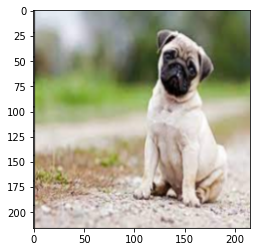

In [8]:
import torch
from torchvision.models import vgg11,resnet18,resnet101,resnext101_32x8d
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import numpy as np
model = vgg11(pretrained=True)
# 这里自己读取一张图片
img_path = './dog.png'
# resize操作是为了和传入神经网络训练图片大小一致
img = cv2.imread(img_path, 1)[:, :, ::-1]   # 1是读取rgb
# 需要将原始图片转为np.float32格式并且在0-1之间
rgb_img = np.float32(img)/255
plt.imshow(rgb_img)

<class 'numpy.ndarray'>


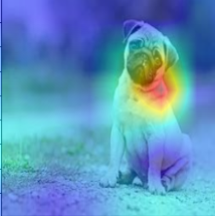

In [9]:
from pytorch_grad_cam import GradCAM,ScoreCAM,GradCAMPlusPlus,AblationCAM,XGradCAM,EigenCAM,FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image,preprocess_image
# preprocess_image作用：归一化图像，并转成tensor
input_tensor = preprocess_image(rgb_img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# 选择目标层
target_layers = [model.features[-1]]
# 选取合适的类激活图，但是ScoreCAM和AblationCAM需要batch_size
cam = GradCAM(model=model,target_layers=target_layers)
# 选定目标类别，如果不设置，则默认为分数最高的那一类
targets = None
grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
grayscale_cam = grayscale_cam[0, :]
cam_img = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)
print(type(cam_img))
Image.fromarray(cam_img)

 **使用FlashTorch快速实现CNN可视化**
 - 随着PyTorch社区的努力，目前已经有不少开源工具能够帮助我们快速实现CNN可视化。这里我们介绍其中的FlashTorch。

In [ ]:
!pip install -i https://pypi.tuna.tsinghua.edu.cn/simple  flashtorch

D:\Anaconda\lib\site-packages\torch\nn\modules\module.py:1033: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


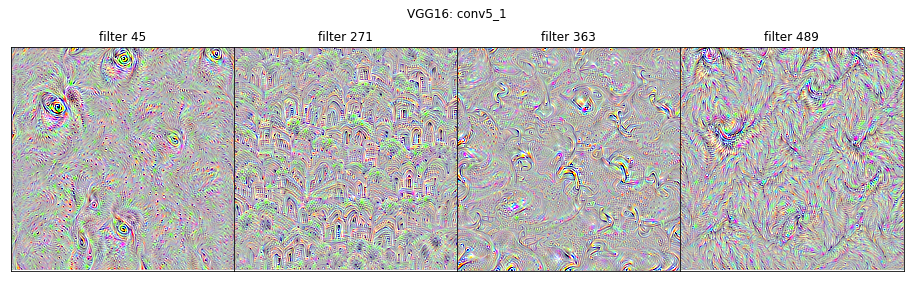

In [10]:
# 可视化卷积核
import torchvision.models as models
from flashtorch.activmax import GradientAscent
model = models.vgg16(pretrained=True)
g_ascent = GradientAscent(model.features)
# specify layer and filter info
conv5_1 = model.features[24]
# 卷积核分别为filte45，filte271，filte363，filte489时候的输出
conv5_1_filters = [45, 271, 363, 489]
g_ascent.visualize(conv5_1, conv5_1_filters, title="VGG16: conv5_1")

## 7.3 使用TensorBoard可视化训练过程

- 可视化基本逻辑：TensorBoard记录模型每一层的feature map、权重和训练loss等，并保存在用户指定的文件夹中，通过网页形式进行可视化展示

In [ ]:
!pip install -i https://pypi.tuna.tsinghua.edu.cn/simple   tensorboard

In [ ]:
!pip install -i https://pypi.tuna.tsinghua.edu.cn/simple    tensorboardX

**TensorBoard的配置与启动**
- 在使用TensorBoard前，我们需要先指定一个文件夹供TensorBoard保存记录下来的数据。然后调用tensorboard中的SummaryWriter作为上述“记录员”

In [11]:
from tensorboardX import SummaryWriter
writer = SummaryWriter('./data/tensorboard/pytorch_tb')

**TensorBoard模型结构可视化**

In [12]:
import torch.nn as nn
import torch
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3,out_channels=32,kernel_size = 3)
        self.pool = nn.MaxPool2d(kernel_size = 2,stride = 2)
        self.conv2 = nn.Conv2d(in_channels=32,out_channels=64,kernel_size = 5)
        self.adaptive_pool = nn.AdaptiveMaxPool2d((1,1))
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(64,32)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(32,1)
        self.sigmoid = nn.Sigmoid()
    def forward(self,x):
        x = self.conv1(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.pool(x)
        x = self.adaptive_pool(x)
        x = self.flatten(x)
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        y = self.sigmoid(x)
        return y
model = Net()
print(model)

Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (adaptive_pool): AdaptiveMaxPool2d(output_size=(1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=64, out_features=32, bias=True)
  (relu): ReLU()
  (linear2): Linear(in_features=32, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


- 可视化模型的思路：都是给定一个输入数据，前向传播后得到模型的结构，再通过TensorBoard进行可视化，使用add_graph：

In [13]:
writer.add_graph(model, input_to_model = torch.rand(1, 3, 224, 224))
writer.close()

In [ ]:
# 启动 tensorboard
%load_ext tensorboard

In [ ]:
# 使用tensorboard进行显示
%tensorboard --logdir ./data/tensorboard/runs

**TensorBoard图像可视化**

当我们做图像相关的任务时，可以方便地将所处理的图片在tensorboard中进行可视化展示。
- 对于单张图片的显示使用add_image
- 对于多张图片的显示使用add_images
- 有时需要使用torchvision.utils.make_grid将多张图片拼成一张图片后，用writer.add_image显示

这里我们使用torchvision的CIFAR10数据集为例：


In [14]:
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
transform_train = transforms.Compose(
[transforms.ToTensor()])
transform_test = transforms.Compose(
[transforms.ToTensor()])
train_data = datasets.CIFAR10(".", train=True, download=True,
transform=transform_train)
test_data = datasets.CIFAR10(".", train=False, download=True,
transform=transform_test)
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64)
images, labels = next(iter(train_loader))
# 仅查看一张图片
writer = SummaryWriter('./data/tensorboard/pytorch_tb')
writer.add_image('images[0]', images[0])
writer.close()
# 将多张图片拼接成一张图片，中间用黑色网格分割
# create grid of images
writer = SummaryWriter('./data/tensorboard/pytorch_tb')
img_grid = torchvision.utils.make_grid(images)
writer.add_image('image_grid', img_grid)
writer.close()
# 将多张图片直接写入
writer = SummaryWriter('./data/tensorboard/pytorch_tb')
writer.add_images("images",images,global_step = 0)
writer.close()

Files already downloaded and verified
Files already downloaded and verified


In [15]:
# 使用tensorboard进行显示
%tensorboard  --logdir ./data/tensorboard/pytorch_tb

UsageError: Line magic function `%tensorboard` not found.


**TensorBoard连续变量可视化**
- TensorBoard可以用来可视化连续变量（或时序变量）的变化过程，通过add_scalar实现：

In [ ]:
writer = SummaryWriter('./data/tensorboard/add_scalar')
for i in range(500):
    x = i
    y = x**2
    writer.add_scalar("x", x, i) #日志中记录x在第step i 的值
    writer.add_scalar("y", y, i) #日志中记录y在第step i 的值
writer.close()

In [ ]:
# 使用tensorboard进行显示
%tensorboard  --logdir ./data/tensorboard/add_scalar

In [ ]:
# 在一张图中显示两张图片
writer1 = SummaryWriter('./data/tensorboard/add_scalar')
writer2 = SummaryWriter('./data/tensorboard/add_scalar')
for i in range(500):
    x = i
    y = x*2
    writer1.add_scalar("same", x, i) #日志中记录x在第step i 的值
    writer2.add_scalar("same", y, i) #日志中记录y在第step i 的值
writer1.close()
writer2.close()

**TensorBoard参数分布可视化**

In [16]:
import torch
import numpy as np
# 创建正态分布的张量模拟参数矩阵
def norm(mean, std):
    t = std * torch.randn((100, 20)) + mean
    return t
writer = SummaryWriter('./pytorch_tb')
for step, mean in enumerate(range(-10, 10, 1)):
    w = norm(mean, 1)
    writer.add_histogram("w", w, step)
    writer.flush()
writer.close()

In [ ]:
# 使用tensorboard进行显示
%tensorboard  --logdir ./pytorch_tb

## 总结

本次任务，主要介绍了Pytoch的可视化，包括网络结构，CNN卷积层可视化以及使用TensorBoard可是化训练过程

1. `torchinfo库`: 可视化模型网络结构，展示模块信息（每一层的类型、输出shape和参数量）、模型整体的参数量、模型大小、一次前向或者反向传播需要的内存大小等。
2. `grad-cam库`：可视化重要像素点，能够快速确定重要区域，进行可解释性分析和模型优化改进。
3. `TensorBoard工具`: 可视化模型结构、图像、连续变量和参数分布等。